In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML


plt.rcParams["animation.html"] = "jshtml"

In [2]:
map_oceans = plt.imread("../../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../../maps/LOTR_MAPS_ridges.png")

wmap_oceans = popdyn.reader.extract_weightmap(map_oceans)
wmap_rivers = popdyn.reader.extract_weightmap(map_rivers)
wmap_hills = popdyn.reader.extract_weightmap(map_hills)
wmap_mountains = popdyn.reader.extract_weightmap(map_mountains)
wmap_ridges = popdyn.reader.extract_weightmap(map_ridges)

wmap_land = popdyn.reader.invert_weightmap(wmap_oceans)

In [4]:
raw_elevation = np.load("lotr_map_raw_elevation.npz")["arr_0"]

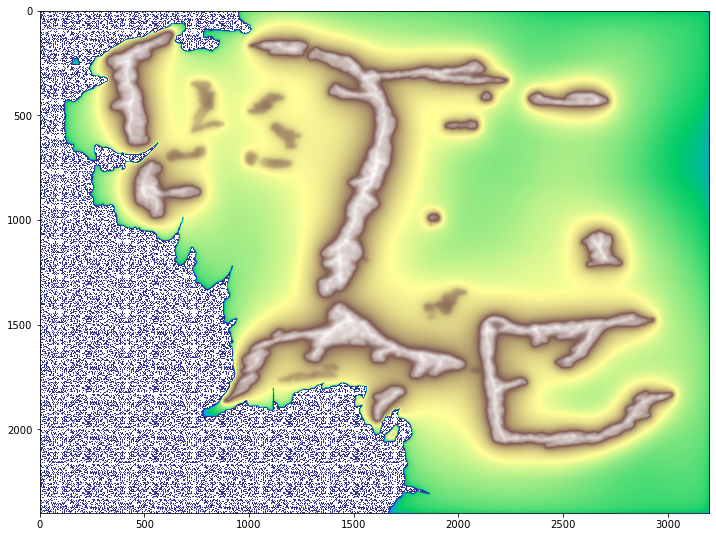

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(raw_elevation, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm(), )


In [3]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for key in self.layers:
            rl = self.rules[key]
            canvas = rl.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.update_maps()